<h1>Basic portfolio strategies</h1>

We have financial data for the components of the SBF 120 (as of the end of 2018) spanning the period from 2011 to the present.
Our objectives are to:

- Acquire and process the data in an efficient, Pythonic manner.
- Identify the top 10 stocks based on the highest market capitalization as of the end of 2018.
- Implement three simple strategies using object-oriented Python.
- Backtest these three strategies over the year 2019 and compare their performances in terms of the Sharpe ratio and maximum drawdown. We also aim to evaluate the respective performances of these three portfolios throughout 2019.

Let's first start by the first step :

In [317]:
# Imports the numpy library, which provides numerical operations and 
# support for large arrays and matrices.
import numpy as np

# Imports the pandas library, which offers data structures and operations 
# for data manipulation and analysis, especially with tabular data 
# (e.g., spreadsheets).
import pandas as pd

# Imports the pyplot interface from the matplotlib library, allowing 
# for the creation of visualizations like plots and charts.
import matplotlib.pyplot as plt

# Imports the cvxpy library, a tool for modeling and solving 
# convex optimization problems.
import cvxpy as cp

# Imports the 'minimize' function from the scipy.optimize module, 
# which provides algorithms for (non convex) function minimization.
from scipy.optimize import minimize


## Data Loading and Processing

In [318]:
%%time
# Measuring the execution time of the cell using Jupyter magic command '%%time'.

# Loading the data
data = pd.read_excel('sbf120_as_of_end_2018.xlsx', sheet_name = 'Data')

CPU times: total: 14.6 s
Wall time: 25.5 s


Now, let's retrieve the market capitalization data for all 120 assets. This step is crucial for us to subsequently obtain the prices of the selected 10 stocks, which is why we address it before extracting the prices.

We are specifically focusing on the market capitalization data from 31st December 2018 to 31st December 2019, as this is the only time range we'll use for market capitalization in this analysis.

In [319]:
%%time
# Using the %%timeit Jupyter magic command to measure the execution time of the entire cell multiple times and provide an average runtime.
# This is used to compare the performance of different approaches to the same problem.

# Creating a list to hold the market capitalization dataframes for each of the 120 assets for the period from 31-12-2018 to 31-12-2019.
df_mkt_cap_list = []

# Iterating over each of the 120 assets to extract market cap data.
for i in range(120):
    # Extracting columns corresponding to dates and market cap for the current asset.
    mkt_cap_data = data.iloc[:, [3*i, 3*i+2]].copy()
    # Removing rows with any missing values.
    mkt_cap_data.dropna(inplace=True)
    # Converting the date column from Excel's serial format to a datetime format.
    mkt_cap_data.iloc[:, 0] = pd.to_datetime(mkt_cap_data.iloc[:, 0], unit='D', origin='1899-12-30')
    # Renaming columns to standardize naming across all dataframes.
    mkt_cap_data.rename(columns={mkt_cap_data.columns[0]: 'Date', mkt_cap_data.columns[1]: mkt_cap_data.columns[0]}, inplace=True)
    # Setting the 'Date' column as the index.
    mkt_cap_data.set_index('Date', inplace=True)
    # Filtering the data to include only rows from 31-12-2018 to 31-12-2019.
    mkt_cap_data = mkt_cap_data['2018-12-31':'2019-12-31']
    # Appending the filtered market cap dataframe to the list.
    df_mkt_cap_list.append(mkt_cap_data)

# Aggregating data from all the individual dataframes into one combined dataframe.
agg_mkt_cap_data = df_mkt_cap_list[0]
for df in df_mkt_cap_list[1:]:
    agg_mkt_cap_data = agg_mkt_cap_data.join(df, how='outer', sort=True)


CPU times: total: 984 ms
Wall time: 1 s


Now, let's examine the market capitalization data for any missing values. In practice, such missing data can arise for various reasons. For instance, a company might not trade for a day due to reasons such as a public holiday, a trading halt, or company-specific events like a significant announcement. Such gaps in trading can result in the absence of market capitalization data for that day.

In [320]:
agg_mkt_cap_data.isna().sum().sum()

153

As observed, there are missing values. Let's address this by using the "bfill" method, which stands for 'backward fill'. This method fills the missing value with the subsequent valid entry in the data. In other words, if a particular data point is missing, it will be filled with the next available non-missing value.

In [321]:
agg_mkt_cap_data.fillna(method = 'bfill', inplace = True)


Now that we've addressed the missing values in the market capitalization data, we are ready to select the top 10 stocks based on their market capitalization.

In [322]:
# Get the market cap values from the last available date, sort them in descending order, and pick the top 10 stocks.
stocks = agg_mkt_cap_data.iloc[-1].sort_values(ascending=False)[:10].index.values

# Retrieve the column indices in the original 'data' dataframe for the selected top 10 stocks.
data_stock_indexes = [data.columns.get_loc(col) for col in stocks]

# Edit the market cap dataframe to include only the top 10 stocks.
agg_mkt_cap_data = agg_mkt_cap_data[stocks] 



# Note: It's important to first select the stocks based on market cap and then retrieve their prices. 
# Doing it in reverse could result in missing some relevant data.


Now, we're set to retrieve the price data! We'll specifically gather data from 1st January 2017 to 31st December 2019. This timeframe serves our purposes precisely: we'll utilize the 2017-2018 data for covariance matrix estimation and the 2019 data for backtesting.

In [323]:
%%time

price_df_list = []
for i in data_stock_indexes:
    price_data = data.iloc[:, i:i+2].copy()
    price_data.dropna(inplace=True)
    price_data.iloc[:, 0] = pd.to_datetime(price_data.iloc[:, 0], unit='D', origin='1899-12-30')
    price_data.rename(columns={price_data.columns[0]: 'Date', price_data.columns[1]: price_data.columns[0]}, inplace=True)
    price_data.set_index('Date', inplace=True)
    price_data = price_data['2016-12-31':'2019-12-31']
    price_df_list.append(price_data)

agg_price_data = price_df_list[0]
for df in price_df_list[1:]:
    agg_price_data = agg_price_data.join(df, how='outer', sort=True)

CPU times: total: 62.5 ms
Wall time: 75.8 ms


Like with market cap data, any missing values in our price data can be filled using the 'bfill' method, which takes the next available value.

In [324]:
agg_price_data.fillna(method = 'bfill', inplace = True)

We're nearing the end of our data acquisition phase! Next, we'll partition the dataset into two separate dataframes, each corresponding to its relevant timeframe.


In [325]:
%%time

# Filter the aggregated price data to only include entries from 31/12/2018 to 31/12/2019.
agg_price_data_2019 = agg_price_data[(agg_price_data.index >= '2018-12-31') & (agg_price_data.index <= '2019-12-31')]

# Similarly, filter the aggregated market cap data for the same timeframe.
agg_mkt_cap_data_2019 = agg_mkt_cap_data[(agg_mkt_cap_data.index >= '2018-12-31') & (agg_mkt_cap_data.index <= '2019-12-31')]

# Calculate the daily returns for the selected stocks in 2019 and remove any rows with missing values.
returns_2019 = agg_price_data_2019[stocks].pct_change().dropna()

# Filter the aggregated price data to cover the period from 01/01/2017 to 31/12/2018.
agg_price_data_2017_2018 = agg_price_data[(agg_price_data.index >= '2016-12-31') & (agg_price_data.index <= '2018-12-31')]

# Calculate the daily returns for the selected stocks in 2017-2018 and remove any rows with missing values.
returns_2017_2018 = agg_price_data_2017_2018[stocks].pct_change().dropna()

CPU times: total: 0 ns
Wall time: 8.08 ms


## Portfolio strategies 

We are now going to implement 3 different porftolio optimization strategies. Each strategy will take the form of a class, which will inherit from a general class called "Strategy". This class is defined below 

In [326]:
class Strategy:

    """
    Class containing the different methods which will be inherited by each portfolio optimization strategy.
    
    Parameters

    ----------
    name : Name given to the strategy
    returns : series of stock returns
    ----------
   
     """

    #Initialize Strategy class
    def __init__(self, name, returns) -> None:
        self.name = name
        self.returns = returns
        self.pnl = np.c_[np.array([1000000.]), 1000000.*np.cumprod(1.+returns.to_numpy()).reshape(1,-1)].flatten()

    #Compute volatilty of the strategy
    def volatility(self):
        return np.std(self.returns)*np.sqrt(252)

    #Compute Sharpe Ratio of the strategy
    def sharpe_ratio(self):
        return np.mean(self.returns)*np.sqrt(252)/np.std(self.returns)

    #Compute Maximum Drawdown of the strategy
    def max_dd(self):
        return 1. - np.min(np.flip(np.minimum.accumulate(np.flip(self.pnl)))/self.pnl)


    #Illustrates the strategy's PnL 
    def illustrate(self) -> None:
        fig, ax = plt.subplots(1, 1)
        ax.plot(self.returns.index, self.pnl[1:], 'b', label=self.name + ' (vol: %.2f, Sharpe: %.2f, MDD: %.2f)'%
                                                          (self.volatility(), self.sharpe_ratio(), self.max_dd()))
        ax.set_xlabel('Time')
        ax.set_ylabel('PnL')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(f'PnL of the strategy {self.name}')
        ax.grid(axis='x', linestyle='--')
        fig.tight_layout()
        fig.savefig(f'{self.name}.pdf')
        plt.show()

## Equally-weighted portfolio

The equally weighted portfolio assigns equal weights to each of the stock taken into account.  Since the data that we use has 10 stocks, each weight will be equal to 1/10.

In [327]:
class EquallyWeighted(Strategy):

    """
    Implements a portfolio strategy based on equal weights for each stock. 
    Given that 10 stocks are taken into account, each weight will be equal to 1/10
    
      
    Parameters
    ----------
    name : Name of the strategy
    returns : DataFrame containing the historical returns of the stocks
    capitalizations : DataFrame containing the market capitalizations of the stocks
    """

    def __init__(self, name, returns, capitalizations):


        # Number of assets
        num_columns = len(capitalizations.columns)

        #Computing equal weights : each weight is 1 divided by number of assets
        equal_weights = pd.Series(1 / num_columns, index = capitalizations.index)

        # Copying the dataframe of returns 
        returns_equally = returns.copy()

        # Adding a column of weights 
        returns_equally["Weight"] = equal_weights

        # Compute returns weighted equally
        returns_equally = returns_equally.drop('Weight', axis=1).mul(returns_equally['Weight'], axis=0)
        returns_equally = returns_equally.sum(axis = 1)

        # Call parent class constructor
        super().__init__(name, returns_equally)

## Markowitz Minimum-Variance portfolio

The Markowitz Minimum-Variance portfolio represents an approach which assigns weights to the stocks, which are obtained through an optimization problem. There are 3 different equivalent approaches which will be taken into account

- Thevariance minimization approach
- The return maximization approach
- The user utility maximization approach

The following notations are used :

- $\Sigma$ : Variance-covariance matrix for the future stock returns (that we have to estimate)
- $\mu$ : Vector of means of the future stock returns (that we have to estimate)
- $\text{w}$ : Vector of weights


We begin by implementing the minimum variance appraoch. The statement of the problem is the following :

$$
\begin{equation}
\begin{aligned}
& \text{Minimize} && \mathbf{w}^T \Sigma \mathbf{w} \\
& \text{Subject to} && \sum_{i} w_i = 1 \quad \text{(Total portfolio weight equals 1)} \\
& && \mathbf{\text{portfolio returns}} \geq \text{minimum return} \quad  \\
\end{aligned}
\end{equation}

$$

Here the portfolio returns represent the returns of the portfolio i.e. $\mathbf{\text{portfolio returns}} = \mathbf{w^T}\mathbf{\mu}$

The "minimum return" is a threshold value set by the investor or portfolio manager. It signifies the lowest acceptable return for the portfolio, ensuring that the optimized portfolio does not fall below this return level.


In [328]:
class MarkowitzPortfolio_min_risk(Strategy):

    """
    Class implementing Markowitz minimum-variance portfolio

    Parameters 
    ----------
    returns :  DataFrame containing the historical returns of the stocks
    minimum_return : Value designing the minimum return to be taken into account in the optimization algorithm
    covariance_matrix_estimation : Variance-Covariance matrix of the stock returns
    returns_estimation : Estimated returns of the stocks based on the historical returns 
    ----------
    """

    def __init__(self, name, returns, covariance_matrix_estimation, returns_estimation, minimum_return=0.001) -> None:

        # Define size of the weights vector
        n = len(returns_estimation)
                
        # Define optimization variables
        w = cp.Variable(n)

        # The variance for a portfolio of weights w
        risk = cp.quad_form(w, covariance_matrix_estimation)

        #expected weighted returns
        ret = (returns_estimation)@w

        # Set the objective function
        objective = cp.Minimize(risk)

        # Set the linear constraints
        constraints = [ret >= minimum_return, np.ones(n) @ w == 1]

        # Set the optimization problem
        prob = cp.Problem(objective, constraints)

        # Solve the problem
        portfolio_weights = prob.solve()

        # Calculate portfolio returns based on weights
        returns_markovitz = (returns * portfolio_weights).sum(axis=1)

        #Call parent class constructor
        super().__init__(name, returns_markovitz)

<h3>Extension 1: Markowitz Returns Maximization portfolio</h3>

A second approach on the Markowitz portfolio optimization can be seen a returns maximization approach, under the constraint of an upper bound of the risk level. The problem can be stated as following :


\begin{equation}
\begin{aligned}
& \text{Maximize} && \mu^T \mathbf{w} \\
& \text{Subject to} && \sum_{i} w_i = 1 \quad \text{(Total portfolio weight equals 1)} \\
& && \mathbf{risk} \leq \text{maximum risk level} \quad \\
\end{aligned}
\end{equation}

\begin{equation}
\text{Here the risk is represented by the quadratic form } \mathbf{w}^T \Sigma \mathbf{w}.
\end{equation}

The "maximum risk level" is a threshold value set by the investor or portfolio manager. It signifies the highest acceptable "expected risk" that the investor is willing to take on for the portfolio. This ensures that the optimized portfolio does not exceed this risk level, balancing the desire for high returns with the need for risk management.


In [329]:
class MarkowitzPortfolio_max_return(Strategy):

    """
    Class implementing Markowitz Maximum-Returns portfolio

    Parameters 
    ----------
    returns :  DataFrame containing the historical returns of the stocks
    max_risk : Value designing the maximul risk to be taken into account in the optimization algorithm
    covariance_matrix_estimation : Variance-Covariance matrix of the stock returns
    returns_estimation : Estimated returns of the stocks based on the historical returns
    ----------
    """


    def __init__(self, name, returns, covariance_matrix_estimation, returns_estimation, max_risk=0.1) -> None:

        # Define size of the weights vector
        n = len(returns_estimation)

        # Define optimization variables
        w = cp.Variable(n)

        # The variance for a portfolio of weights w
        risk = cp.quad_form(w, covariance_matrix_estimation)

        #expected weighted returns
        ret = returns_estimation@w

        # Set the objective function
        objective = cp.Maximize(ret)

        # Set the linear constraints
        constraints = [risk <= max_risk, np.ones(n) @ w == 1]

        # Set the optimization problem
        prob = cp.Problem(objective, constraints)

        # Solve the problem
        portfolio_weights = prob.solve(solver=cp.SCS)

        # Calculate portfolio returns based on weights
        returns_markovitz = (returns * portfolio_weights).sum(axis=1)

        #Call parent class constructor
        super().__init__(name, returns_markovitz)


<h3>Extension 2 :  Markowitz Utility maximization portfolio</h3>

The Utility Maximization problem of the porfolio can be stated as the following : 

\begin{equation}
\begin{aligned}
& \text{Maximize} && \mu^T - \delta/2*\mathbf{w}^T\Sigma\mathbf{w} \\
& \text{Subject to} && \mathbf{w}^T \mathbf{1} = 1 \quad \text{(Total portfolio weight equals 1)} \\
\end{aligned}
\end{equation}

The risk-aversion coefficient $\delta$ quantifies an investor's willingness to tolerate risk. A higher value of $\delta$ indicates that the investor is more risk-averse, and thus, would prefer portfolios with lower volatility even if they offer slightly lower expected returns. Conversely, a lower $\delta$ means the investor is more willing to take on risk in exchange for potentially higher returns. The choice of $\delta$ is subjective and should reflect the investor's personal risk preferences.


In [330]:
class MarkowitzPortfolio_utility(Strategy):

    """
    Class implementing Markowitz utility maximization portfolio

    Parameters 
    ----------
    returns :  DataFrame containing the historical returns of the stocks
    riskTolerance : Risk aversion coiefficient
    covariance_matrix_estimation : Variance-Covariance matrix of the stock returns
    returns_estimation : Estimated returns of the stocks based on the historical returns
    ----------
    """

    def __init__(self, name, returns, covariance_matrix_estimation, returns_estimation, riskTolerance=0.0001) -> None:

        # Define size of the weights vector
        n = len(returns_estimation)

        # Define optimization variables
        w = cp.Variable(n)

        # The variance for a portfolio of weights w
        risk = cp.quad_form(w, covariance_matrix_estimation)

        #expected weighted returns
        ret = returns_estimation@w

        # Set the objective function
        objective = cp.Maximize(ret - (riskTolerance/2)*risk)

        # Set the linear constraints
        constraints = [np.ones(n) @ w == 1]

        # Set the optimization problem
        prob = cp.Problem(objective, constraints)

        # Solve the problem
        portfolio_weights = prob.solve()
        

        # Calculate portfolio returns based on weights
        returns_markovitz = (returns * portfolio_weights).sum(axis=1)

        #Call parent class constructor
        super().__init__(name, returns_markovitz)


# ERC Portfolio

The ERC (Equal Risk Contribution) portfolio is based on ensuring that each asset in the portfolio contributes equally to the overall portfolio risk. The main idea behind the ERC portfolio is to find weights such that the risk contribution of each asset is the same.

The formulation can be represented as:

\begin{equation}
\text{For all } i, j, \frac{\partial\sigma}{\partial w_i}(w) = \frac{\partial\sigma}{\partial w_j}(w)
\end{equation}

Where $\sigma$  represents the risk (standard deviation of returns).

This system of equations is the result of an optimization problem which is taken from the article "On the Properties of Equally-Weighted Risk Contributions Portfolios" (Roncalli, T., Teiletche, J. 2008):

\begin{equation}
\begin{align*}
\text{minimize} \quad & \text{Var}(RC) \\
\text{subject to} \quad & \sum_{i=1}^{n} w_i = 1 \\
& w_i \geq 0 \quad \forall i \in \{1, 2, \ldots, n\}
\end{align*}
\end{equation}


Where $w_i \times \frac{\partial\sigma}{\partial w_i}(w)$ denotes the risk contribution of the \(i\)-th asset. The vector \( RC \) represents the risk contribution of each asset, such that 
\begin{equation}
\begin{align*}
RC = \left[ w_1 \times \frac{\partial\sigma}{\partial w_1}(w), w_2 \times \frac{\partial\sigma}{\partial w_2}(w), ..., w_n \times \frac{\partial\sigma}{\partial w_n}(w) \right].
\end{align*}
\end{equation}

The empirical variance of $RC$, denoted as $\text{Var}(RC)$, is given by:

\begin{equation}
\begin{align*}
\text{Var}(RC) = \frac{1}{n} \sum_{i=1}^{n} (RC_i - \bar{RC})^2
\end{align*}
\end{equation}

where  $\bar{RC}$ is the mean of the risk contributions. We aim for the variance of $RC$ to be $0$, ensuring that all risk contributions are equal.






In [331]:
class ERCPortfolio(Strategy):

    
    """
    Class that computes the returns of the Equal Risk Contribution porfolio

    Parameteres
    -----------
    name : Name of the strategy to be implemented
    returns : DataFrame containing the historical returns of the stocks
    covariance_matrix_estimation : Variance-Covariance matrix of the stock returns
    -----------
    """

    def __init__(self, name, returns, covariance_matrix_estimation) -> None:

        n = len(returns.columns)

        # Initial weights (equally distributed)
        w0 = np.array([1.] * n)
        
        # Constraints for the optimizer
        # 1. The weights must sum up to 1
        # 2. The weights must be between 0 and 1 (no shorting and no leverage)
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},)
        bounds = [(0,1) for i in range(n)]

        # The objective function we want to minimize (variance of risk contributions)
        def objective(w):
            portfolio_volatility = np.sqrt(np.dot(w.T, np.dot(covariance_matrix_estimation, w)))
            risk_contributions = w * np.dot(covariance_matrix_estimation, w) / portfolio_volatility

            # Minimize the variance of risk contributions because we want all risk contributions to be equal
            # (i.e. var(risk_contributions) = 0 i.i.f. risk contributions are equal)
            return np.var(risk_contributions)

        # Minimize the objective function
        solution = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)

        # Get the optimal weights
        portfolio_weights = solution.x

        # Calculate portfolio returns based on weights
        returns_erc = (returns * portfolio_weights).sum(axis=1)

        # Call parent class constructor
        super().__init__(name, returns_erc)


<ins>Important Note:</ins> For our educational analysis, we'll maintain constant values for $ \mu $ and $ \Sigma $ based on their estimates from 2017-2018, applying them throughout 2019. This approach helps us avoid look-ahead bias.
Consequently, both the Markowitz and the ERC portfolios remain static during 2019, meaning their weights won't adjust in response to new information arising within the year. For a more responsive strategy, one might consider dynamically estimating $ \mu $ and $ \Sigma $ as new data becomes available.


# Comparison of the 3 strategies

We will now evaluate the performance of the three portfolio strategies by examining the trajectory of their PnL. To do this, we'll first create an instance for each strategy.
For the markowitz strategy, we chose arbitrarily the min_risk one with the parameter "minimum_return = 0.001" which correspond to 0.1% per day. This acts as a baseline return level, ensuring our portfolio isn't overly conservative while optimizing for minimal risk. But one can try with any other extension of the Markowitz Model that we have implemented.

First, let's estimate the covariance matrix and the mean vector for the stock returns of 2019 based on historical data.

In [332]:
# Calculate the correlation matrix for the 2017-2018 price data and convert it to a numpy array.
cov_estimation = agg_price_data_2017_2018.corr().to_numpy()

# Calculate the mean returns for the 2017-2018 to get an estimation of the returns for the year 2019.
returns_estimation = np.array(returns_2017_2018.mean())

Now we can compute the porftolio strategies that we have implemented before.

In [333]:
# Create instance of each class

# Equally weighted portfolio
equally_weighted = EquallyWeighted("Equally Weighted Portfolio", returns_2019, agg_mkt_cap_data)

#Markowitz Minimum-Variance Porftolio
markowitz_portfolio = MarkowitzPortfolio_min_risk("Markowitz Portfolio", returns_2019, cov_estimation, returns_estimation, minimum_return=0.001)

#ERC Portfolio
erc = ERCPortfolio("ERC Portfolio", returns_2019, cov_estimation)

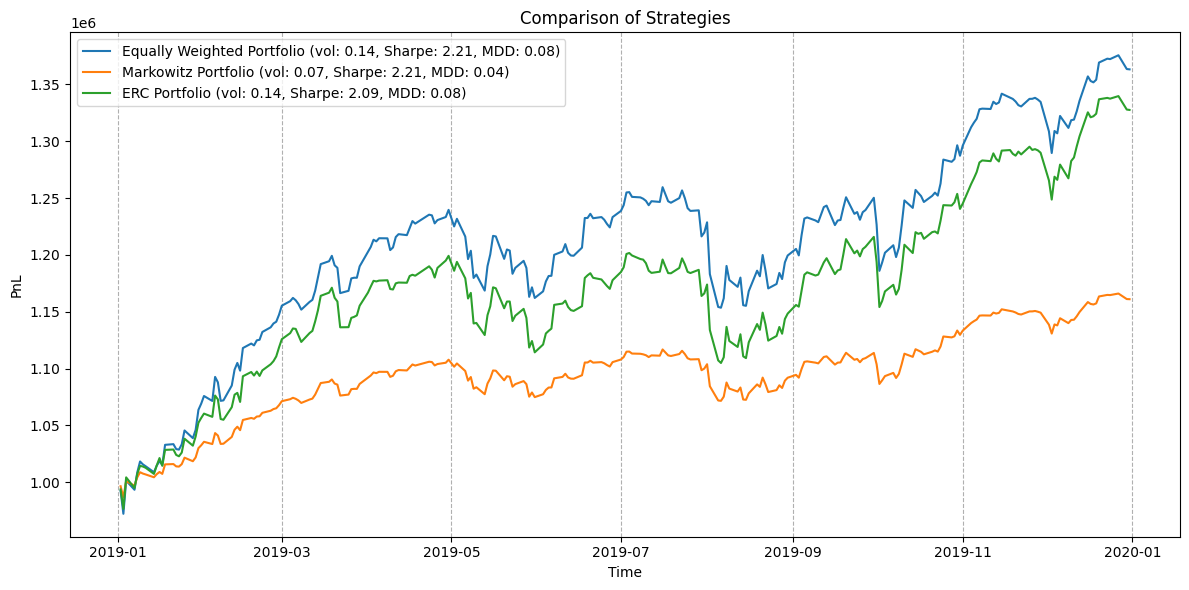

In [334]:
# Function for the combination of the 3 plots in one curve
def combined_illustration(*strategies) -> None:
    plt.figure(figsize=(12, 6))
    
    for strategy in strategies:
        plt.plot(strategy.returns.index, strategy.pnl[1:], label=strategy.name + f' (vol: {strategy.volatility():.2f}, Sharpe: {strategy.sharpe_ratio():.2f}, MDD: {strategy.max_dd():.2f})')
    
    plt.xlabel('Time')
    plt.ylabel('PnL')
    plt.title('Comparison of Strategies')
    plt.legend()
    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

# Illustration of the 3 curves
combined_illustration(equally_weighted, markowitz_portfolio, erc)


The performance ranking, with the Equally Weighted (EQW) portfolio leading, followed by the Equal Risk Contribution (ERC) and then the Markowitz (MW) portfolio, can be attributed to differences in total risk taken by each strategy. Despite all three strategies having similar risk-adjusted returns (as indicated by their roughly equivalent Sharpe ratios), the EQW's simplicity and inherent diversification might have allowed it to capture more absolute returns during favorable market conditions without relying on specific return, volatility, or correlation predictions. 

The ERC portfolio, focusing solely on risk distribution, avoids potential pitfalls of return forecasting, allowing it to surpass the MW portfolio in absolute performance. Meanwhile, the Markowitz approach, <ins>being highly sensitive to its input estimates</ins>, might have taken positions that, while optimal from a risk-adjusted perspective, did not maximize absolute returns.
The ERC portfolio depends on the covariance matrix estimation, unlike the EQW portfolio. The potential oversimplification and inaccuracy of our estimations might be the reason why EQW outperforms ERC.

In essence, while all three strategies achieved similar risk-adjusted performance, their absolute returns differed, likely due to the varying degrees of risk they assumed and the accuracy of their underlying assumptions.
